<a href="https://colab.research.google.com/github/prasanth5reddy/D2L/blob/master/Computer%20Vision/fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
w_dir = '/content/drive/My Drive/Colab/D2L.AI/'
sys.path.append(w_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Installing Libraries

In [2]:
!pip uninstall mxnet && pip install mxnet-cu100

Importing Libraries

In [0]:
from mxnet import gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, utils as gutils,model_zoo
import d2l
import os
import zipfile

Hot Dog Recognition

Get the Data Set

In [0]:
data_dir = w_dir + 'data'
base_url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/'
#fname = gutils.download(base_url + 'gluon/dataset/hotdog.zip', path=data_dir, sha1_hash='fba480ffa8aa7e0febbb511d181409f899b9baa5')
#with zipfile.ZipFile(fname, 'r') as z:
#  z.extractall(data_dir)       

In [5]:
train_imgs = gdata.vision.ImageFolderDataset(os.path.join(data_dir, 'hotdog/train'))
test_imgs = gdata.vision.ImageFolderDataset(os.path.join(data_dir, 'hotdog/test'))

len(train_imgs), len(test_imgs)

(2000, 800)

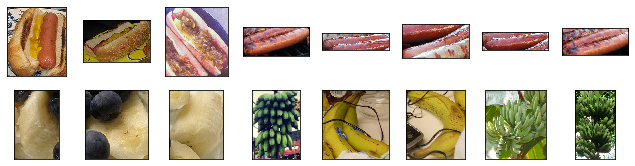

In [6]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4)
d2l.plt.show()

In [0]:
normalize = gdata.vision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = gdata.vision.transforms.Compose([
    gdata.vision.transforms.RandomResizedCrop(224),
    gdata.vision.transforms.RandomFlipLeftRight(),
    gdata.vision.transforms.ToTensor(),
    normalize])

test_augs = gdata.vision.transforms.Compose([
    gdata.vision.transforms.Resize(256),
    gdata.vision.transforms.CenterCrop(224),
    gdata.vision.transforms.ToTensor(),
    normalize])

Define and Initialize the Model

In [0]:
pretrained_net = model_zoo.vision.resnet18_v2(pretrained=True)

In [9]:
pretrained_net.output

Dense(512 -> 1000, linear)

In [0]:
finetune_net = model_zoo.vision.resnet18_v2(classes=2)
finetune_net.features = pretrained_net.features
finetune_net.output.initialize(init.Xavier())
# The model parameters in output will be updated using a learning rate ten times greater
finetune_net.output.collect_params().setattr('lr_mult', 10)

Fine Tune the Model

In [0]:
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5):
  train_iter = gdata.DataLoader(train_imgs.transform_first(train_augs), batch_size, shuffle=True)
  test_iter = gdata.DataLoader(test_imgs.transform_first(test_augs), batch_size)
  ctx = d2l.try_all_gpus()
  net.collect_params().reset_ctx(ctx)
  net.hybridize()
  loss = gloss.SoftmaxCELoss()
  trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate, 'wd': 0.001})
  d2l.train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs)

In [12]:
train_fine_tuning(finetune_net, 0.01)

training on [gpu(0)]
epoch 1, loss 2.9884, train acc 0.699, test acc 0.889, time 20.0 sec
epoch 2, loss 0.3221, train acc 0.903, test acc 0.910, time 16.6 sec
epoch 3, loss 0.2860, train acc 0.914, test acc 0.920, time 16.7 sec
epoch 4, loss 0.4077, train acc 0.892, test acc 0.896, time 16.7 sec
epoch 5, loss 0.3304, train acc 0.908, test acc 0.936, time 16.7 sec


In [13]:
scratch_net = model_zoo.vision.resnet18_v2(classes=2)
scratch_net.initialize(init=init.Xavier())
train_fine_tuning(scratch_net, 0.1)

training on [gpu(0)]
epoch 1, loss 0.6119, train acc 0.721, test acc 0.741, time 17.1 sec
epoch 2, loss 0.4062, train acc 0.824, test acc 0.728, time 17.0 sec
epoch 3, loss 0.4003, train acc 0.817, test acc 0.844, time 17.3 sec
epoch 4, loss 0.3830, train acc 0.836, test acc 0.835, time 17.4 sec
epoch 5, loss 0.3560, train acc 0.843, test acc 0.873, time 16.8 sec
